## tracking the detected pupil



In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import cv2


## and now... move your eyes, not the head

we grab 42 frames. why 42? I recommend to not move the head (hold them in your hands) and to look at the led of your webcam. when it's lit, move your eyes evenly on the screen.

In [3]:
from LeCheapEyeTracker import Camera
N_frame = 42
cam = Camera()
import time
time.sleep(1.)
img0 = cam.grab()
H, W, three = img0.shape
movie = np.zeros((H, W, 3, N_frame), dtype=np.uint8)
for i in range(N_frame):
    movie[:, :, :, i] = cam.grab()
    time.sleep(0.3)
    print(i)
img = cam.grab()
cam.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41


(720, 1280, 3, 42) 0 255


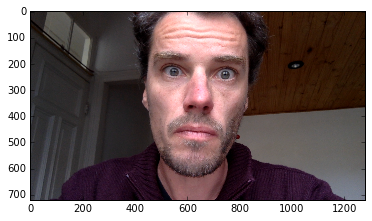

In [4]:
print(movie.shape, movie.min(), movie.max())
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))

In [12]:
import cv2

face_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_eye.xml')
lefteye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_lefteye_2splits.xml')
righteye_cascade = cv2.CascadeClassifier('/Users/laurentperrinet/pool/libs/vision/opencv/data/haarcascades/haarcascade_righteye_2splits.xml')

def get_just_one(image, cascade):
    # We set set minNeighbors=1 then increase it until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter
    features, minNeighbors = [], 1
    while len(features) == 0 and minNeighbors<20:
        features = cascade.detectMultiScale(image, 1.1, minNeighbors) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
        minNeighbors += 1
        #print(minNeighbors)
    return features[0], minNeighbors

img_ = img0.copy()
(x,y,w,h), minNeighbors = get_just_one(img_, face_cascade)
(lex, ley, lew, leh), minNeighbors = get_just_one(roi_color, lefteye_cascade)
(rex, rey, rew, reh), minNeighbors = get_just_one(roi_color, righteye_cascade)

left_eye_movie = np.zeros((leh, lew, 3, N_frame), dtype=np.uint8)
right_eye_movie = np.zeros((reh, rew, 3, N_frame), dtype=np.uint8)
for i in range(N_frame):
    out_color = movie[y:y+h, x:x+w, :, i]
    left_eye_movie[:, :, :, i] = out_color[ley:ley+leh, lex:lex+lew]
    right_eye_movie[:, :, :, i] = out_color[rey:rey+reh, rex:rex+rew]



##  segmenting using dynamics

- the eyebrow on upper quarter 
- the skin is all around
- the reflection is white and small
- the iris is round, darker


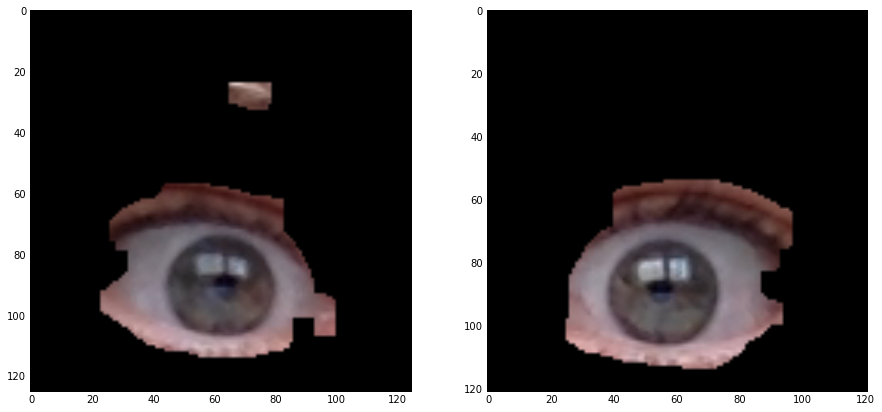

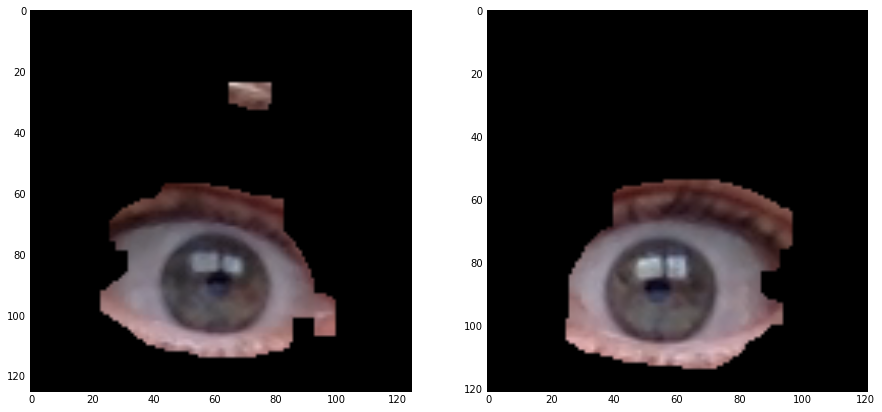

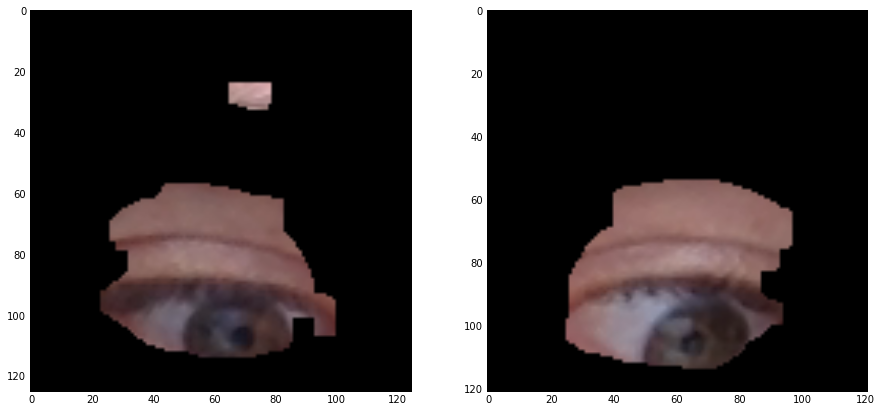

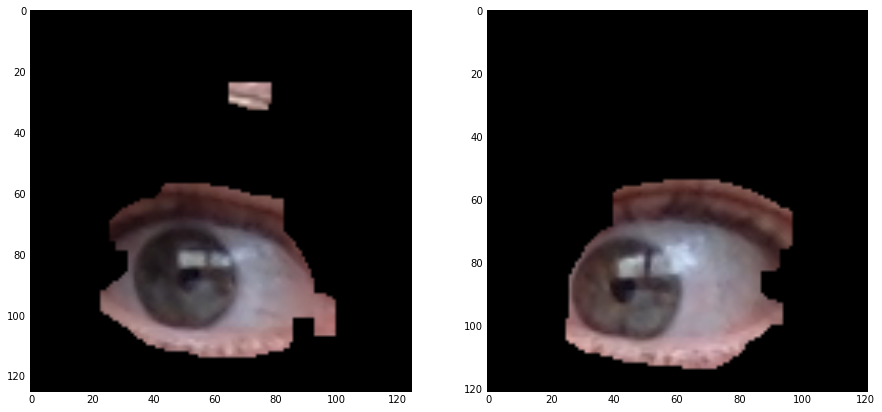

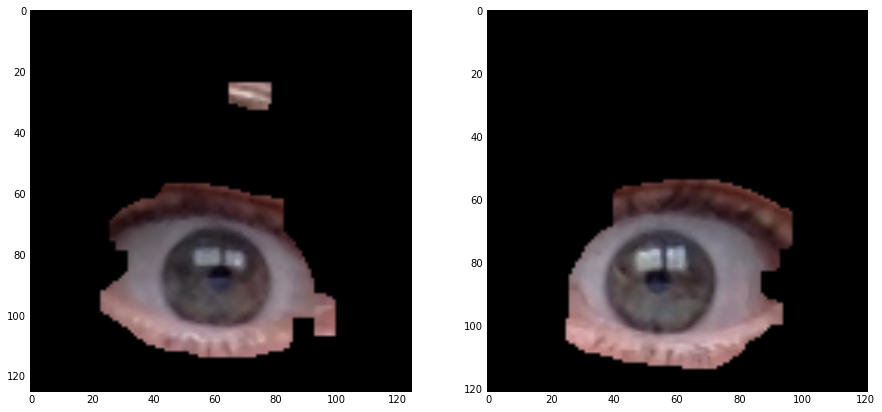

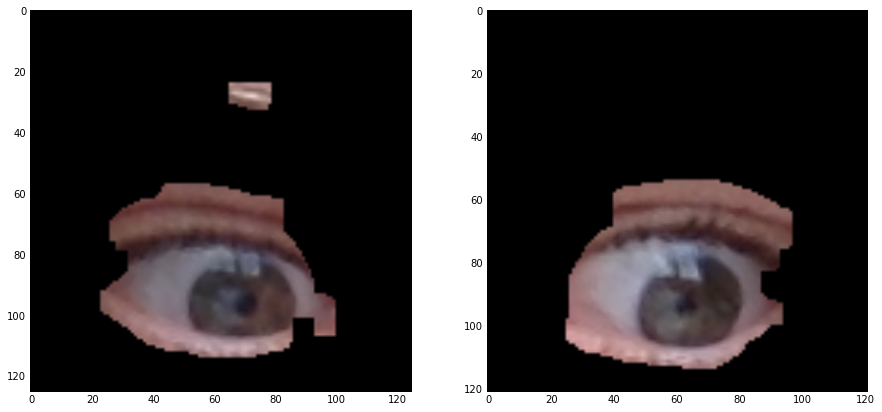

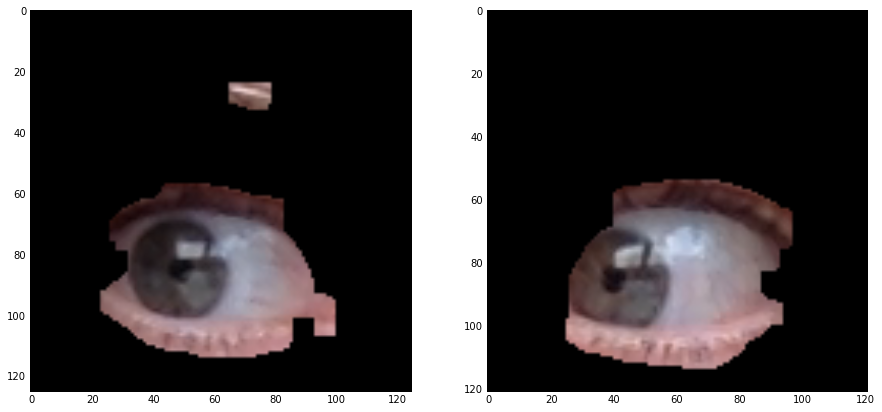

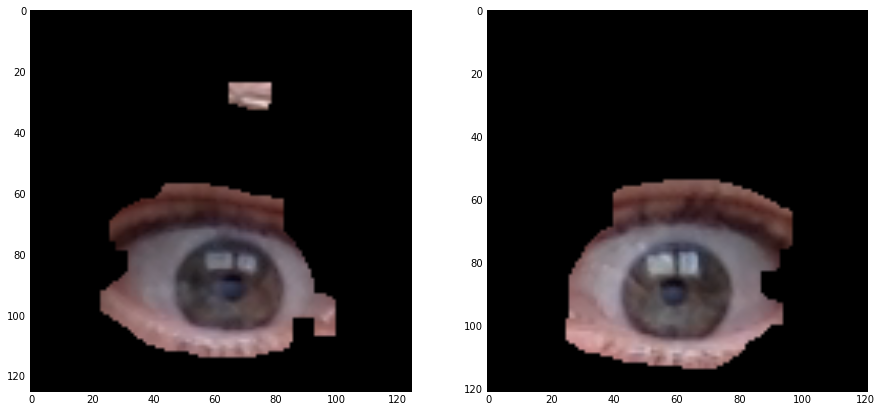

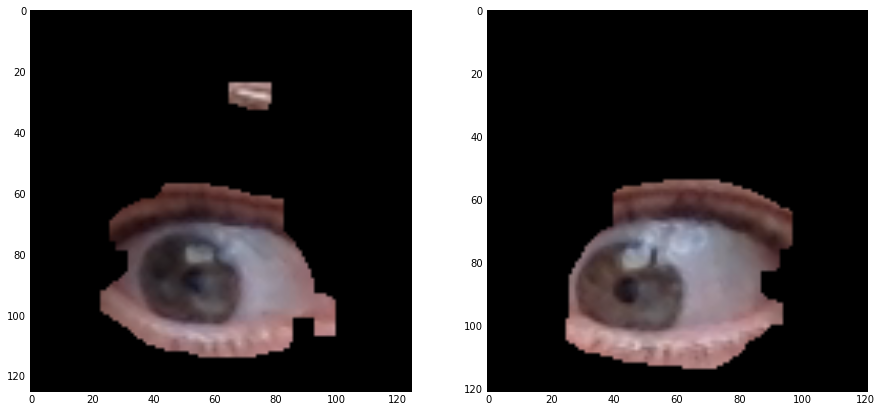

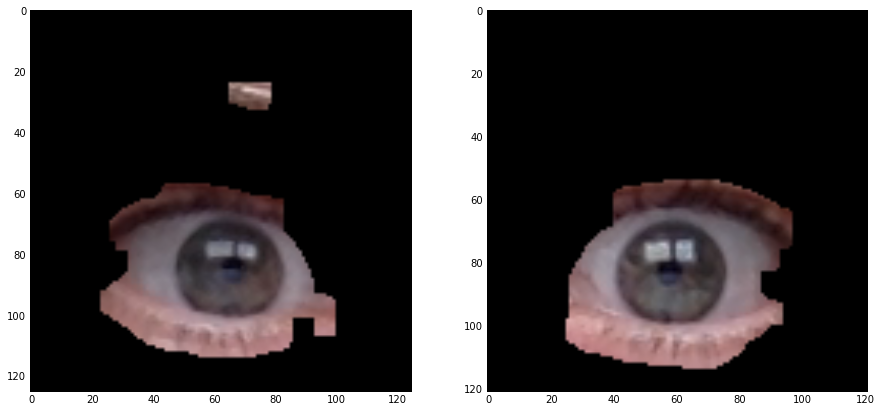

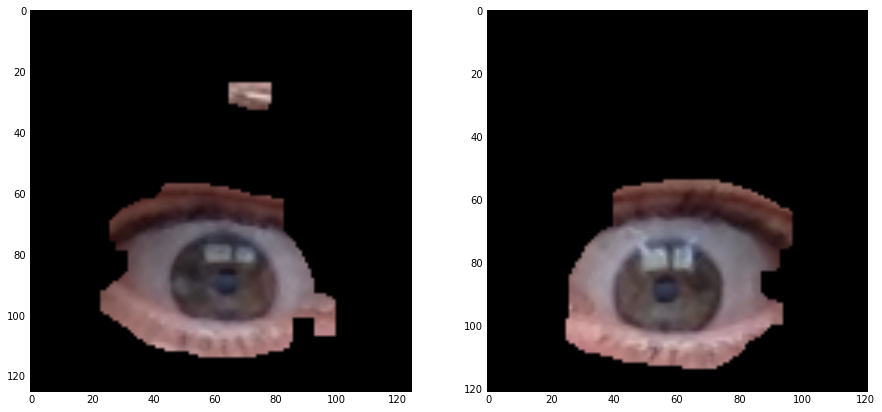

In [13]:


masks = []

for i, eye_movie in enumerate([right_eye_movie, left_eye_movie]):
    eye_movie_b = np.zeros_like(eye_movie)
    for i in range(N_frame):
        eye_movie_b[:, :, :, i] = cv2.medianBlur(eye_movie[:, :, :, i], 7)

    #print(eye_movie.min(), eye_movie.max(), type(eye_movie))
    eye_movie_b = eye_movie_b.astype(np.float)
    std_eye = eye_movie_b.std(axis=-1).mean(axis=-1)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye /= std_eye.max()
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye *= 255
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    std_eye = std_eye.astype(np.uint8)
    #print(std_eye.min(), std_eye.max(), type(std_eye))
    ret_skin, skin_mask = cv2.threshold(std_eye, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((7, 7))
    for ii_ in range(3):
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel)   
        skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel)    
    #print(skin_mask.min(), skin_mask.max(), type(skin_mask))

    # threshold and binary AND
    skin_mask = cv2.merge((skin_mask,skin_mask,skin_mask))
    #print(skin_mask.min(), skin_mask.max(), skin_mask.shape, type(skin_mask))
    masks.append(skin_mask)

for i_t in range(N_frame):
    if i_t % 4 ==0: fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
    for i, (eye_movie, skin_mask) in enumerate(zip([right_eye_movie, left_eye_movie], masks)):
        eye = cv2.bitwise_and(eye_movie[:, :, :, i_t].astype(np.uint8), skin_mask)
        if i_t % 4 ==0: axs[i].imshow(eye)
        axs[i].imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))

## tracking this target image



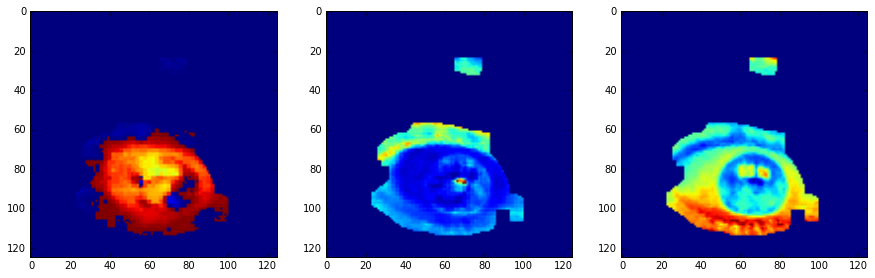

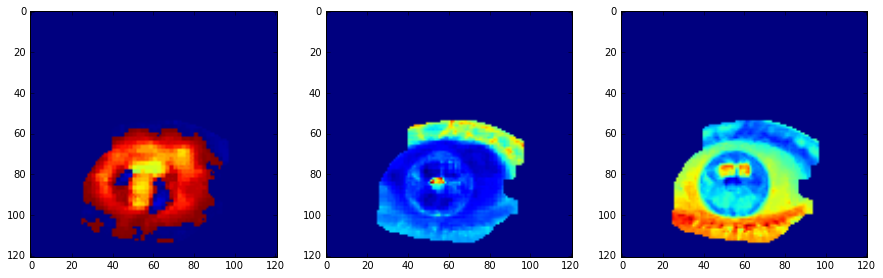

In [19]:
for i, (eye_movie, skin_mask) in enumerate(zip([right_eye_movie, left_eye_movie], masks)):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    eye = cv2.bitwise_and(eye_movie[:, :, :, 0].astype(np.uint8), skin_mask)
    hsv = cv2.cvtColor(eye, cv2.COLOR_BGR2HSV)
    for i in range (3): 
        axs[i].imshow(hsv[:, :, i])

Let's use camshift to track the first image we grabed:

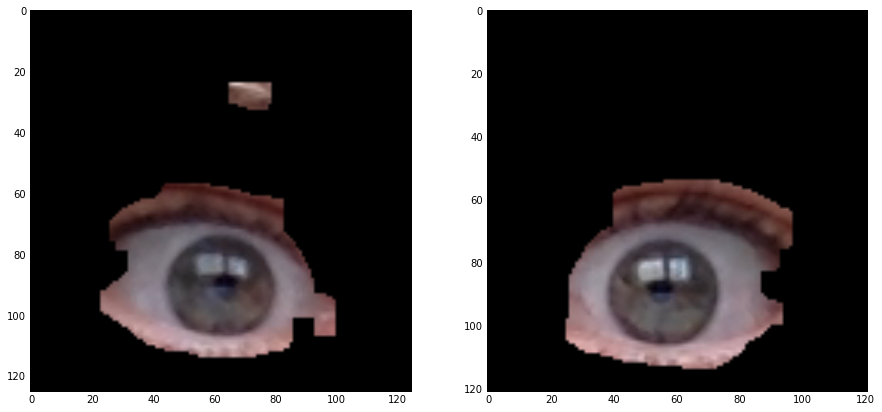

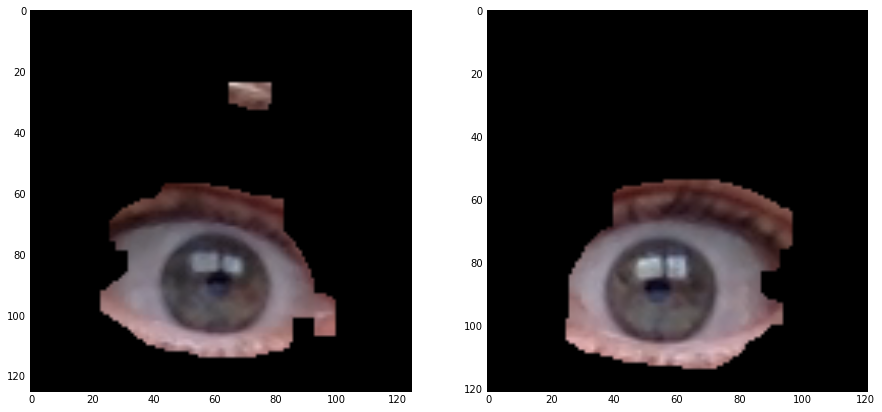

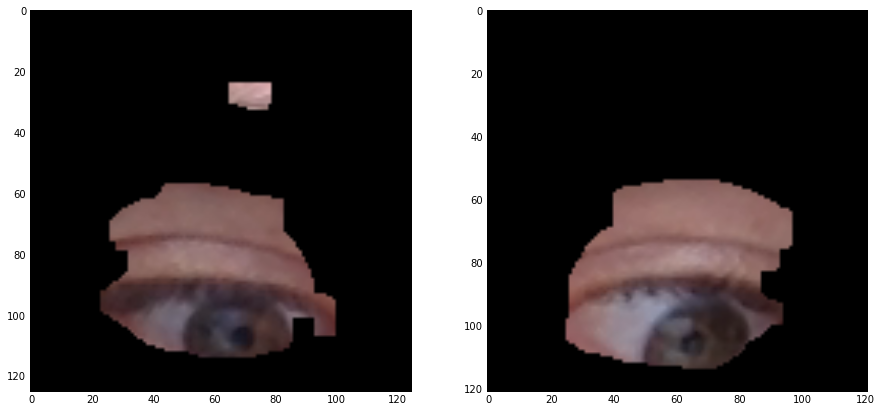

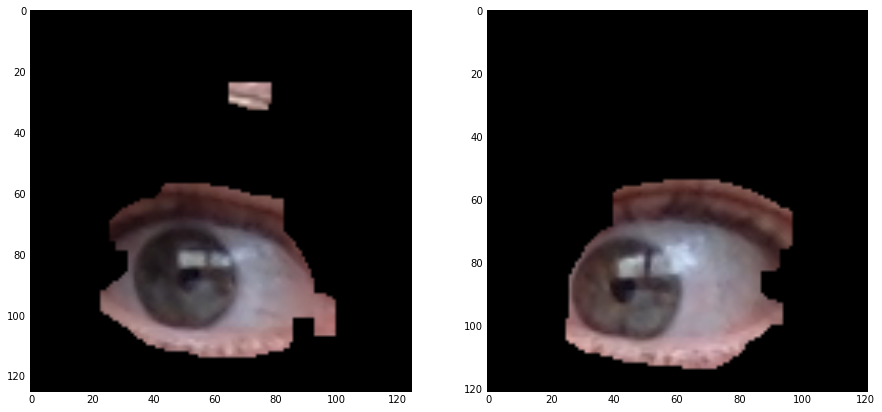

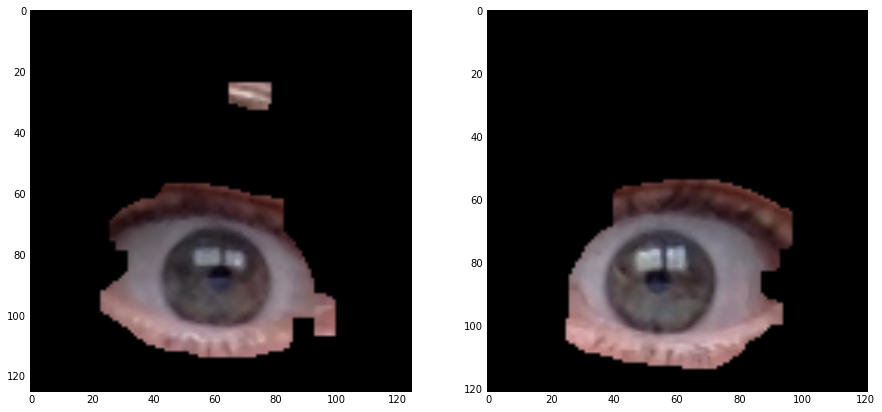

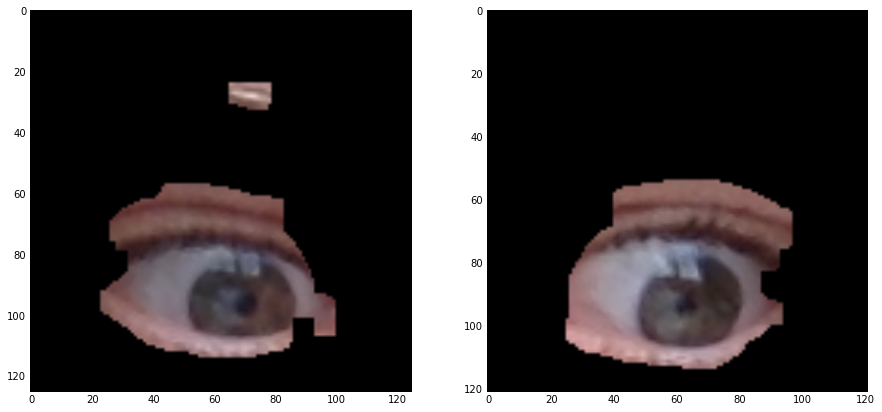

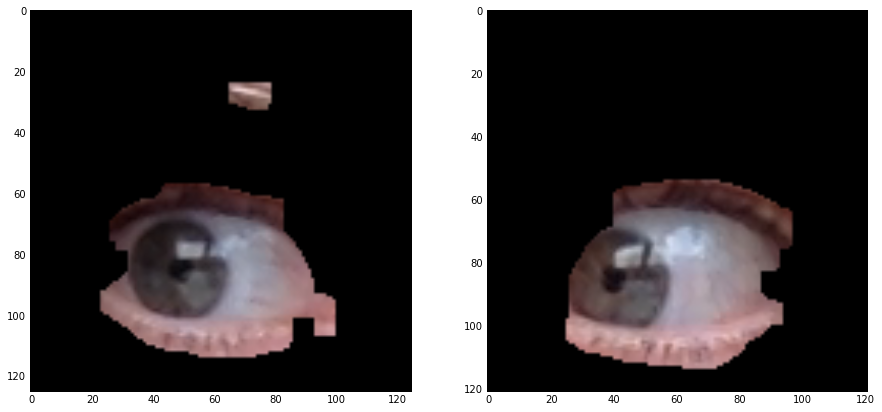

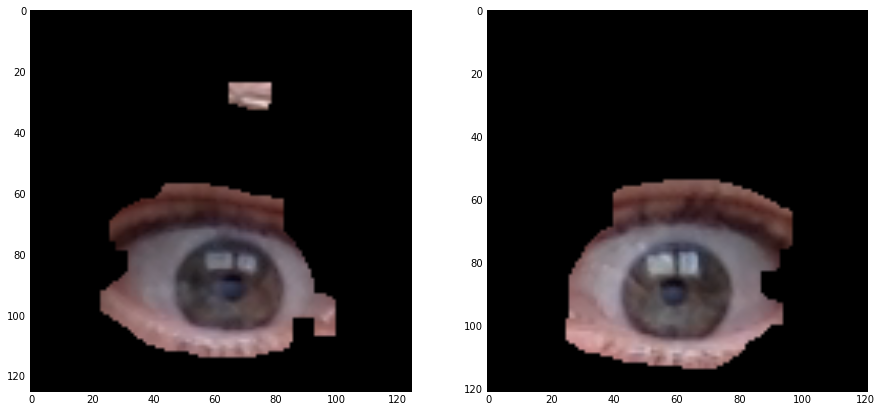

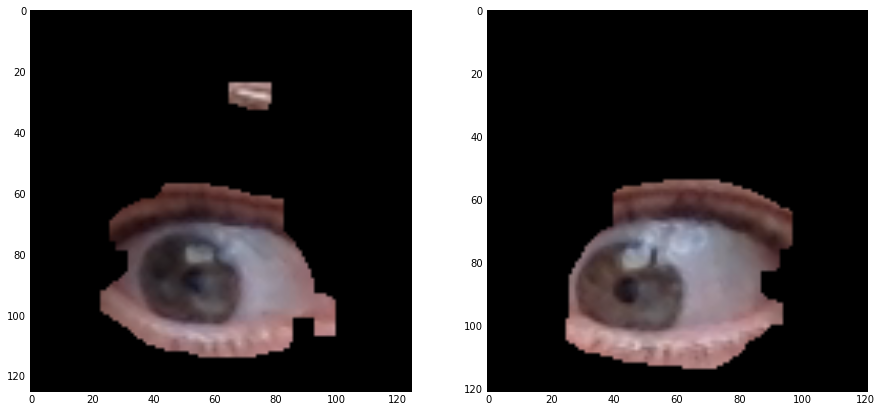

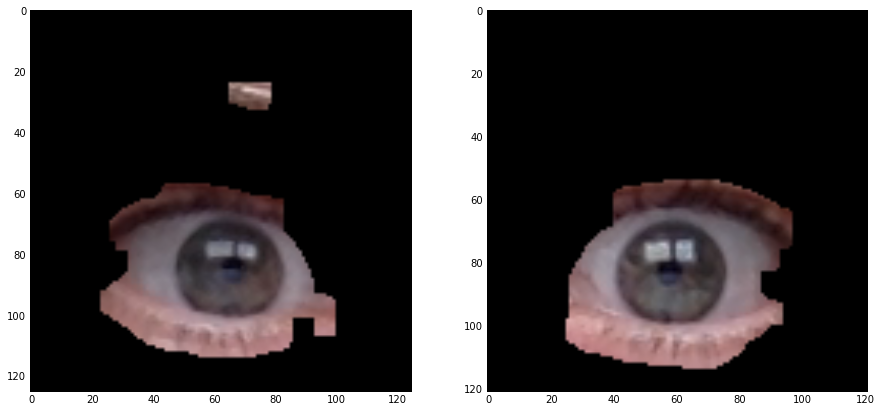

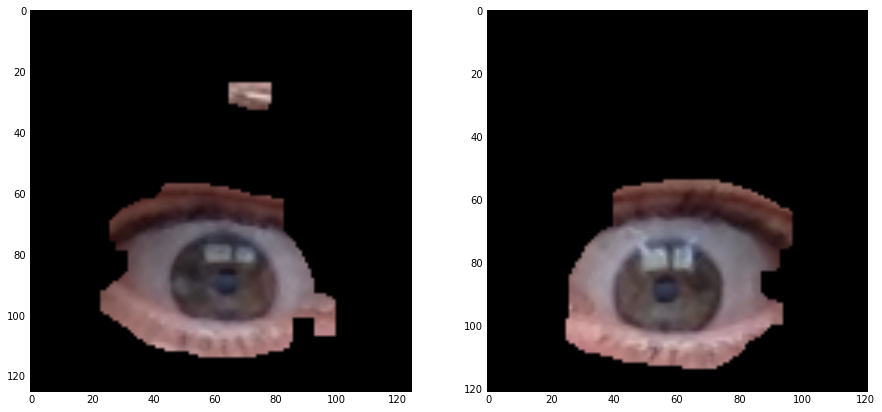

In [13]:
targets = []
for i, (eye_movie, skin_mask) in enumerate(zip([right_eye_movie, left_eye_movie], masks)):
    targets.append(cv2.bitwise_and(eye_movie[:, :, :, 0].astype(np.uint8), skin_mask))

for i_t in range(N_frame):
    if i_t % 4 ==0: fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
    for i, (eye_movie, skin_mask) in enumerate(zip([right_eye_movie, left_eye_movie], masks)):
        eye = cv2.bitwise_and(eye_movie[:, :, :, i_t].astype(np.uint8), skin_mask)
        if i_t % 4 ==0: axs[i].imshow(eye)
        axs[i].imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))